**Информация о датасете**

Столбец profile_id – id юзера

Столбец event_json содержит данные о событии показа рекламы:
- ad_type – формат рекламы (int, banner или rv)
- placement – когда/где был показ рекламы в игре
- view_index – номер показа конкретного формата рекламы для юзера (не поддерживается для баннеров)
- revenue – доход от конкретного показа рекламы (eCPM = revenue * 1000)
- ads_ltv – накапливающийся доход от рекламы, равен сумме всех revenue юзера
- network_name – рекламная сеть, от которой был показ

In [132]:
# импортируем необходимые библиотеки для работы
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context(
    "talk", font_scale=1.5, rc={"lines.linewidth": 2.5, "figure.figsize": (20, 20)}
)
plt.rcParams["figure.figsize"] = (20, 10)

In [2]:
df = pd.read_csv(r'C:\Users\admen\Downloads\df2.csv')

In [3]:
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   profile_id               860065 non-null  object 
 1   os_version               860079 non-null  object 
 2   device_manufacturer      860079 non-null  object 
 3   device_model             860079 non-null  object 
 4   device_type              860079 non-null  object 
 5   device_locale            860079 non-null  object 
 6   event_name               860079 non-null  object 
 7   event_datetime           860079 non-null  object 
 8   event_timestamp          860079 non-null  int64  
 9   event_receive_datetime   860079 non-null  object 
 10  event_receive_timestamp  860079 non-null  int64  
 11  connection_type          860079 non-null  object 
 12  operator_name            841200 non-null  object 
 13  country_iso_code         860079 non-null  object 
 14  city

Найдем, какой процент доходов содержит информацию о городе юзера

In [205]:
city_nonnull_percent = round((536371/860079) * 100, 2)
city_nonnull_percent

62.36

In [4]:
%time
# посчитаем eCPM и вытащим тип рекламы из event_json. А также уберем event_json для экономии памяти
df["eCPM"] = df["event_json"].apply(lambda x: eval(x)["revenue"] * 1000)
df["ad_type"] = df["event_json"].apply(lambda x: eval(x)["ad_type"])
df = df.drop(columns=["event_json"])

CPU times: total: 0 ns
Wall time: 0 ns


**Задание 1.**

a) Посчитаем среднее eCPM по каждому пользователю и построим распределение

In [5]:
avg_ecpm_by_user = df.groupby(["profile_id"], as_index=True)['eCPM'].mean()

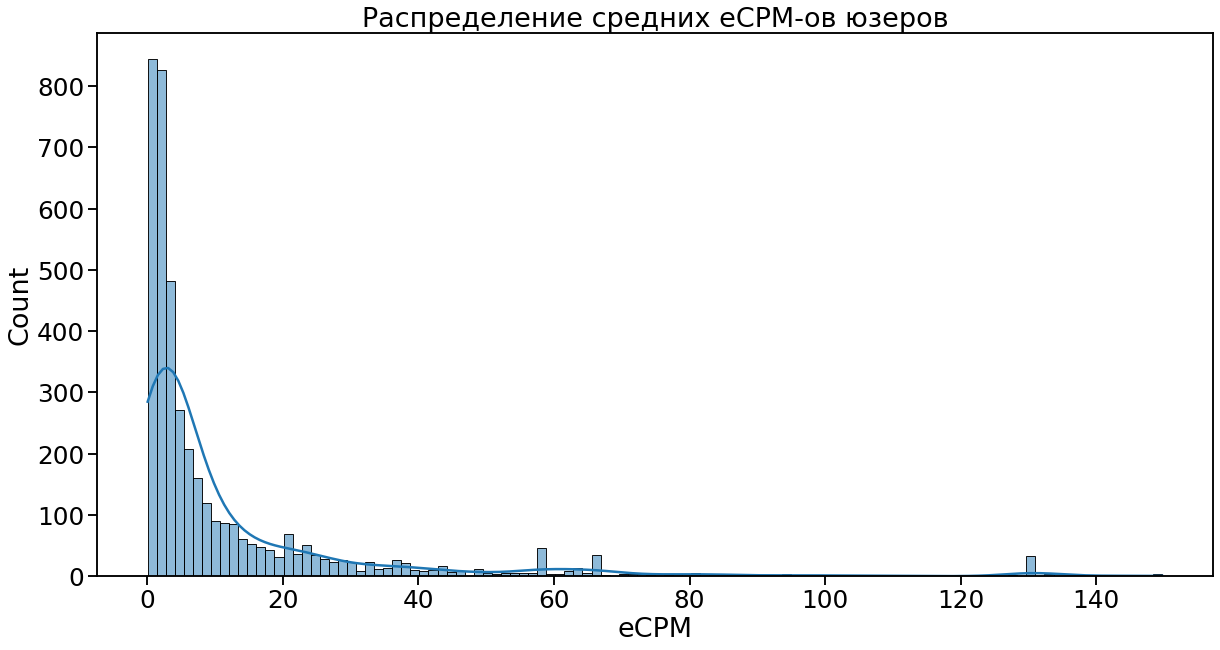

In [6]:
sns.histplot(data=avg_ecpm_by_user[avg_ecpm_by_user<150], kde=True)
plt.title("Распределение средних eCPM-ов юзеров");

Как видно из гистограмы - распределение средних напоминает экспоненциальное. Из чего можно сделать вывод, что большинство пользователей не приносят много прибыли.

b) Построим распределение средних по городам, ос. И посмотрим какие из них в среднем приносят больше прибыли с помощью bar plot.

In [200]:
city_counts = df["city"].value_counts()

In [201]:
sum(city_counts > 30)
# будем брать города только те, у которых есть больше 30 записей, чтобы уменьшить диспресию

693

In [202]:
cities = df[df["city"].isin(city_counts[city_counts>30].index)]

In [203]:
avg_ecpm_by_city = cities.groupby(["city"], as_index=True)['eCPM'].mean()

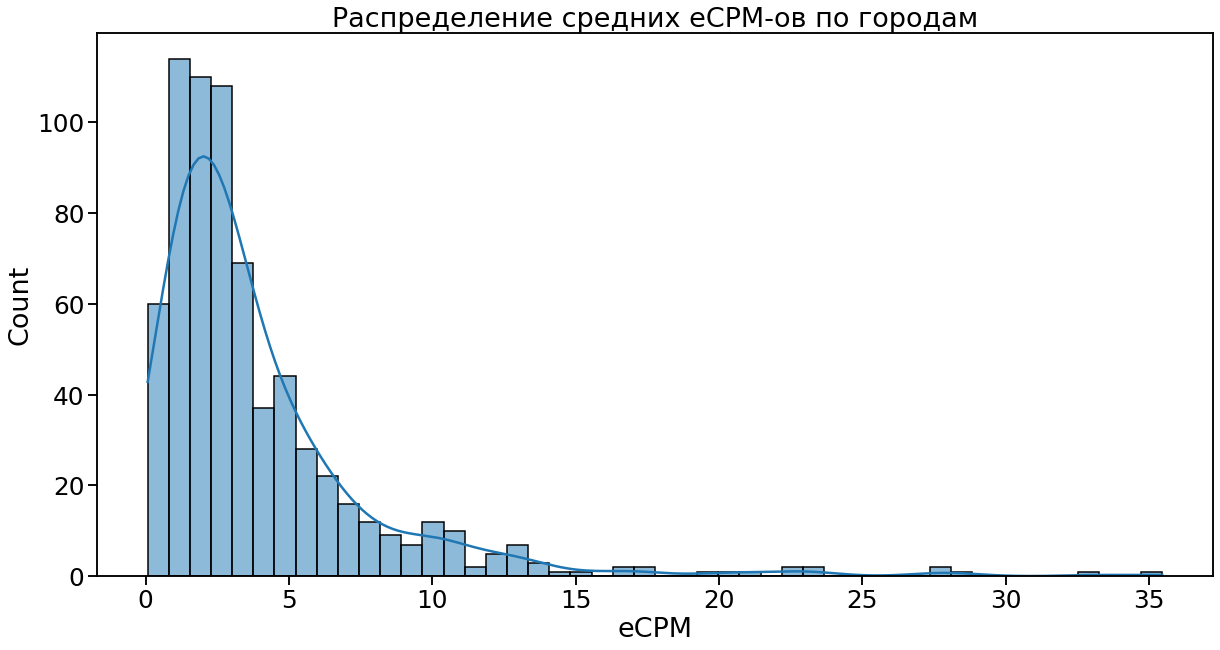

In [204]:
sns.histplot(data=avg_ecpm_by_city, kde=True)
plt.title("Распределение средних eCPM-ов по городам");

In [191]:
top10_avg_ecpm_by_city = pd.DataFrame(avg_ecpm_by_city.sort_values(ascending=False)[:10])

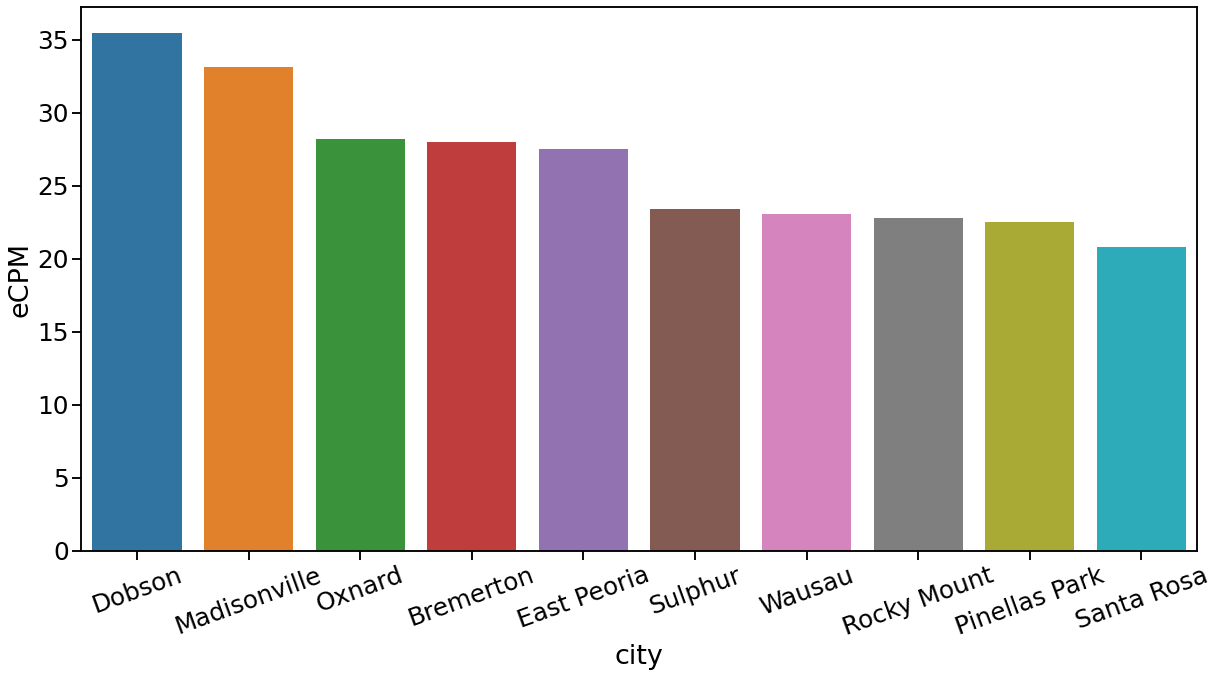

In [192]:
sns.barplot(x=top10_avg_ecpm_by_city.index, y=top10_avg_ecpm_by_city["eCPM"])
plt.xticks(rotation=20);

In [14]:
avg_ecpm_by_os = df.groupby(["os_version"], as_index=True)['eCPM'].mean().sort_values(ascending=False)

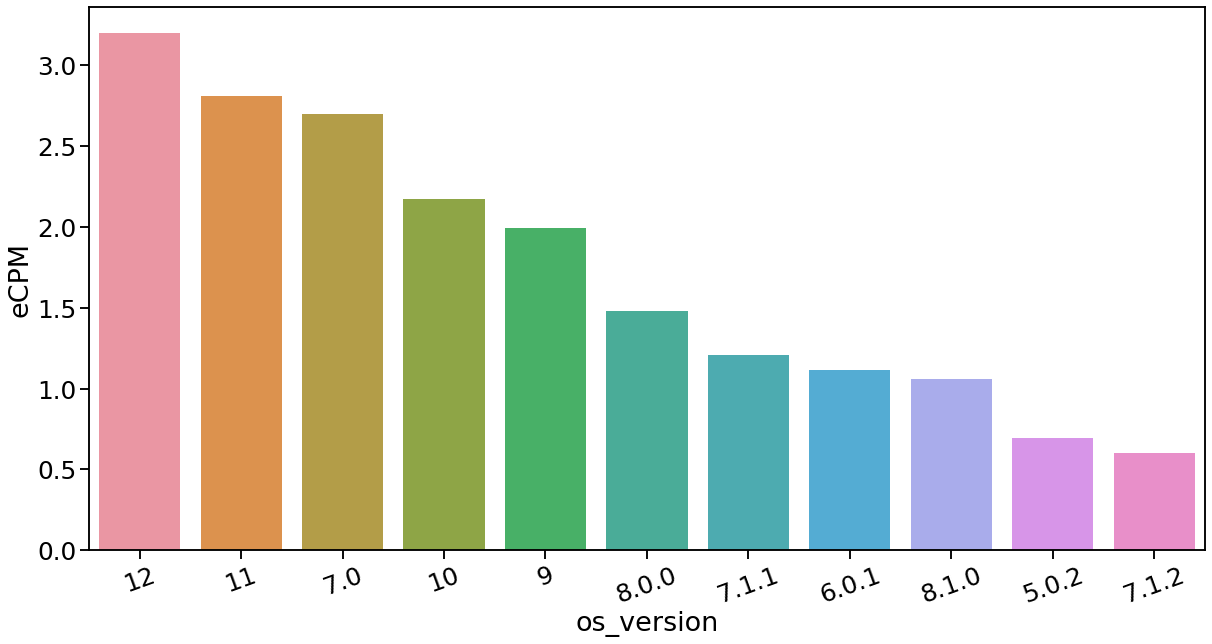

In [15]:
sns.barplot(x=avg_ecpm_by_os.index, y=avg_ecpm_by_os)
plt.xticks(rotation=20);

Отлично видно, что чем новее версия ОС у пользователя, тем больше реклама приносит дохода

c) суммарные доходы по городам, версиям ОС

In [16]:
sum_ecpm_by_city = cities.groupby(["city"], as_index=True)['eCPM'].sum().sort_values(ascending=False)[:20]

In [17]:
sum_ecpm_by_os = df.groupby(["os_version"], as_index=True)['eCPM'].sum().sort_values(ascending=False)

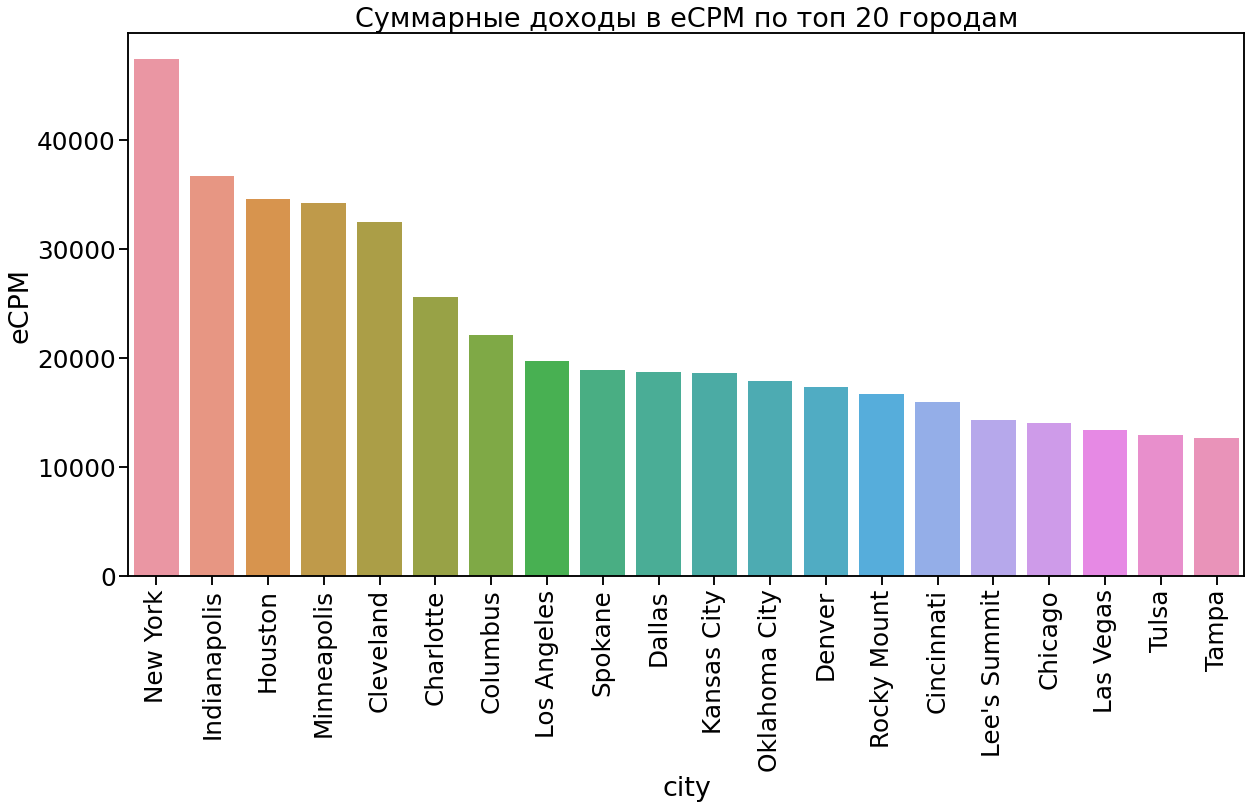

In [18]:
sns.barplot(x=sum_ecpm_by_city.index, y=sum_ecpm_by_city)
plt.title("Суммарные доходы в eCPM по топ 20 городам")
plt.xticks(rotation=90);

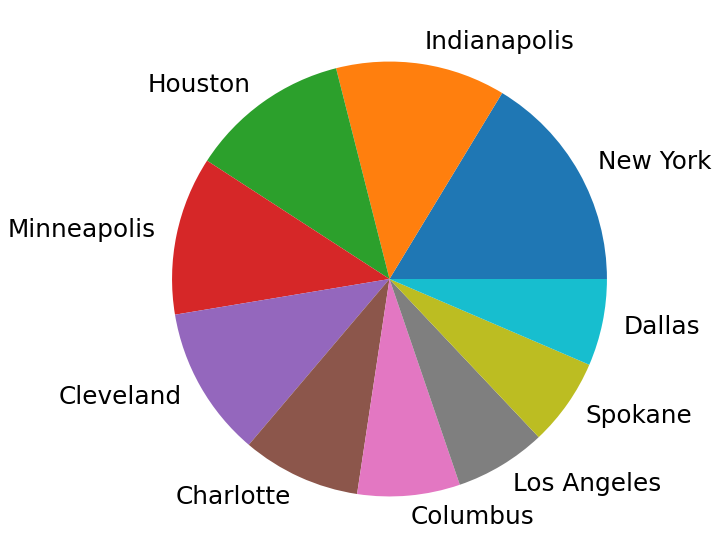

In [19]:
plt.pie(sum_ecpm_by_city[:10], labels = sum_ecpm_by_city[:10].index);

In [33]:
user_count_by_city = df.groupby(["city"], as_index=True)['profile_id'].count().sort_values(ascending=False)

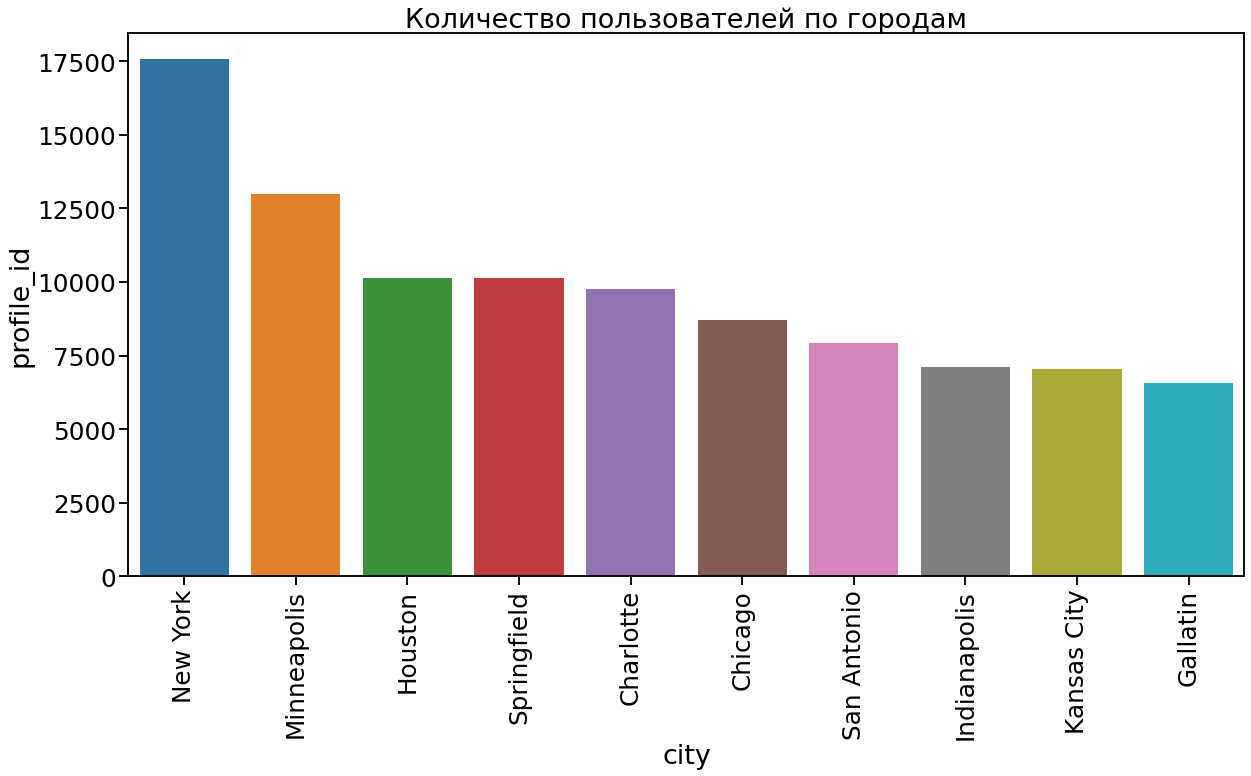

In [40]:
sns.barplot(x=user_count_by_city[:10].index, y=user_count_by_city[:10])
plt.title("Количество пользователей по городам")
plt.xticks(rotation=90);

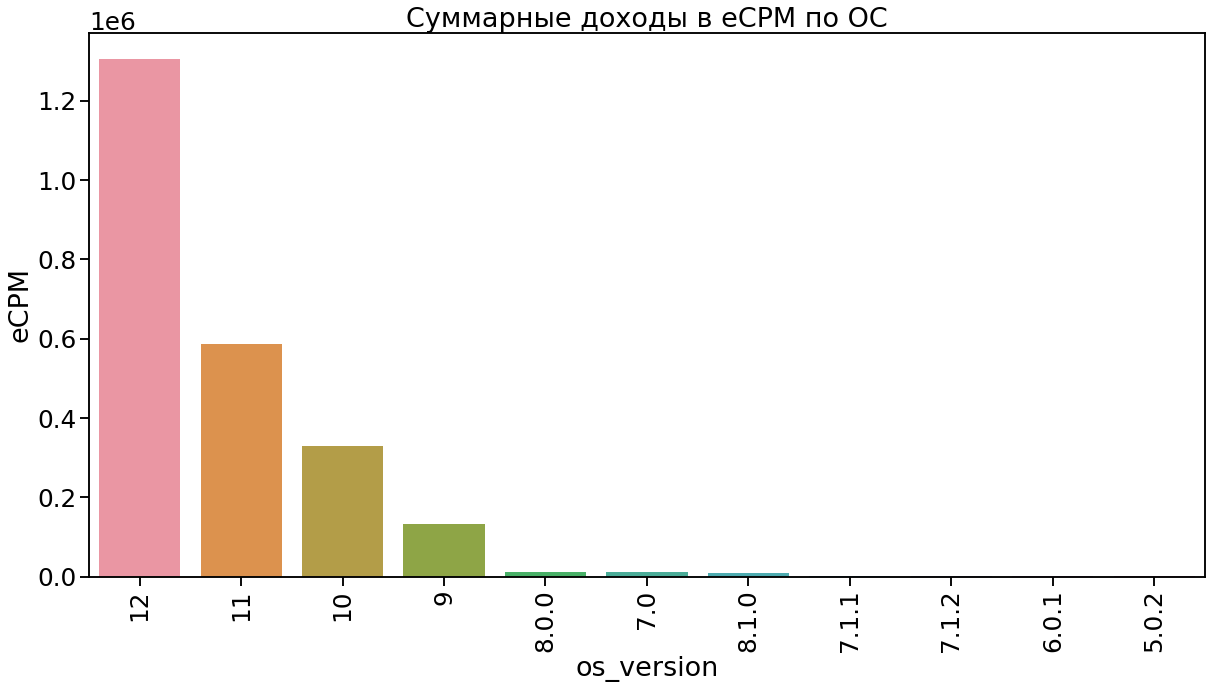

In [20]:
sns.barplot(x=sum_ecpm_by_os.index, y=sum_ecpm_by_os)
plt.title("Суммарные доходы в eCPM по ОС")
plt.xticks(rotation=90);

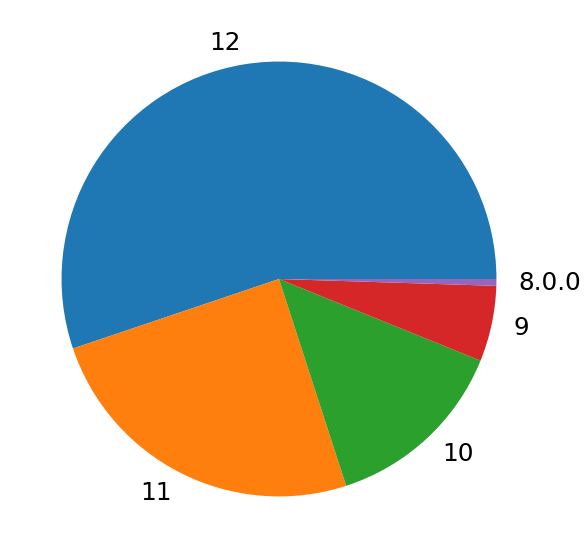

In [21]:
plt.pie(sum_ecpm_by_os[:5], labels = sum_ecpm_by_os[:5].index);

In [134]:
user_count_by_os = df.groupby(["os_version"], as_index=True)['profile_id'].count().sort_values(ascending=False)

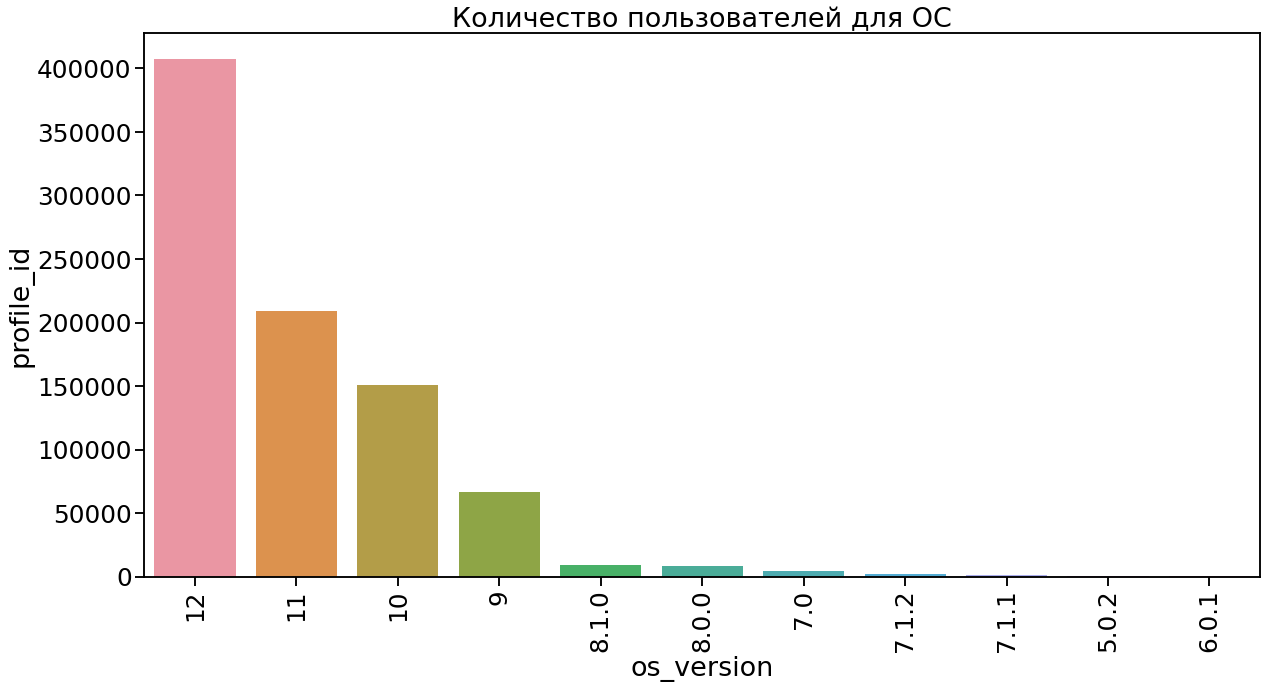

In [135]:
sns.barplot(x=user_count_by_os.index, y=user_count_by_os)
plt.title("Количество пользователей для ОС")
plt.xticks(rotation=90);

На графике видно, что преобладающая часть пользователей использует приложение на последних версиях ОС

Задание 2)
сравним 2 выборки, в первой будут eCPM топ1 города по средним, во второй топ 10

In [133]:
stat, p = ttest_ind(df[df["city"] == "Dobson"]["eCPM"], df[df["city"] == "Santa Rosa"]["eCPM"])
p

0.10412652006950616

p value > 0.05, из чего можно сделать вывод, что с 95% вероятностью средние в двух разных городах статистически не различны

Вывод:
в результате проведенного исследования становится ясно, что большая часть пользователей использует устройства с последними версиями ОС. Также на графиках видно, что больше всего суммарный доход от пользователей из Нью Йорка за счет их количества, однако по среднему eCPM Нью Йорк не входит даже в топ 10 городов. Можно также заметить Индианаполис, который имеет более чем в два раза меньшее количество пользователей, чем Нью Йорк, но по суммарной прибыли занимает вторую строчку.